## Is deformation radius important for model training?

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../../modules/')

In [3]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-12 02:23:58.980797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-12 02:23:58.994518: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 02:23:58.998668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
experiment_config= {'simulation_names':['DG','P2L'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'Rd_nondim'
                                          #'mag_nabla_h_widened',
                                          #'filter_scale', 
                                          #'mag_nabla_u_widened',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'Rd_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim',
                                          'vphp_rotated_nondim'],
                    
                    'coeff_channels'  : [], 

                    'extra_channels'   : ['uphp_rotated',
                                          'vphp_rotated', 
                                          'mag_nabla_h_widened',
                                          'mag_nabla_u_widened',
                                          'filter_scale'],

                    'use_coeff_channels': False,

                    'all_time_range': slice(200, 3600),
                    'train_time_range': slice(0, 2048),
                    'test_time_range' : slice(-128, None),
                    'eval_time_range' : slice(-256, -128),
                    'num_train_batches': 128, 
                    'num_test_batches' : 8, 

                    #'num_inputs': 55, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/'
                    
            }
experiment_config['num_inputs'] = len(experiment_config['input_channels']) * experiment_config['window_size']**2

In [6]:
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'],
                             time_sel = experiment_config['all_time_range'])

In [7]:
DT.simulation_data['DG']['100']

DataTree('100', parent="DG")
    Dimensions:                      (Time: 3400, xh: 100, yh: 108, zl: 2, Xn: 3,
                                      Yn: 3, zi: 3)
    Coordinates:
      * Time                         (Time) object 27kB 0006-07-04 00:00:00 ... 0...
      * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
      * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
      * zl                           (zl) float64 16B 1.035e+03 1.036e+03
      * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
    Dimensions without coordinates: Xn, Yn
    Data variables: (12/67)
        dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        ...                           ...
        uphp_rotated_nondim          (Time, zl, yh, xh) float64 588MB dask.array<chunksize=(16, 2, 107, 99), meta=np.ndarray>
        vphp_rotated_nondim          (Time, zl, yh, xh) float64 588MB dask.array<chunksize=(16, 2, 107, 99), meta=np.ndarray>
        uphp_nondim                  (Time, zl, yh, xh) float64 588MB dask.array<chunksize=(16, 2, 107, 99), meta=np.ndarray>
        vphp_nondim                  (Time, zl, yh, xh) float64 588MB dask.array<chunksize=(16, 2, 107, 99), meta=np.ndarray>
        Rd_nondim                    (Time, yh, xh) float64 294MB dask.array<chunksize=(16, 108, 100), meta=np.ndarray>
        single_layer_mask            (Time, yh, xh) float64 294MB dask.array<chunksize=(16, 108, 100), meta=np.ndarray>
    Attributes:
        simulation_name:  DG
        filter_scale:     100
        source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
        description:      Dataset for DG experiment at 100 km resolution

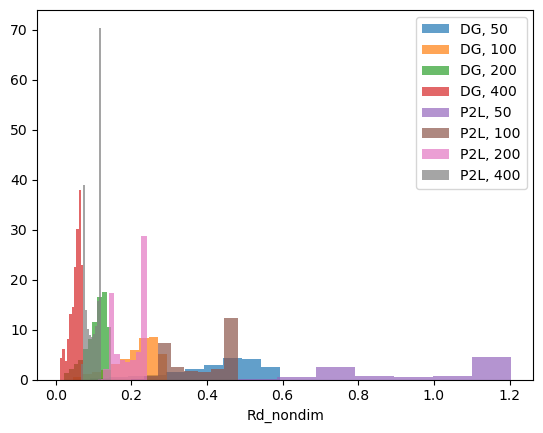

In [17]:
DT.simulation_data['DG']['50'].Rd_nondim.plot(density=True, alpha=0.7, label='DG, 50')
DT.simulation_data['DG']['100'].Rd_nondim.plot(density=True, alpha=0.7, label='DG, 100');
DT.simulation_data['DG']['200'].Rd_nondim.plot(density=True, alpha=0.7, label='DG, 200');
DT.simulation_data['DG']['400'].Rd_nondim.plot(density=True, alpha=0.7, label='DG, 400');

DT.simulation_data['P2L']['50'].Rd_nondim.plot(density=True, alpha=0.7, label='P2L, 50')
DT.simulation_data['P2L']['100'].Rd_nondim.plot(density=True, alpha=0.7, label='P2L, 100');
DT.simulation_data['P2L']['200'].Rd_nondim.plot(density=True, alpha=0.7, label='P2L, 200');
DT.simulation_data['P2L']['400'].Rd_nondim.plot(density=True, alpha=0.7, label='P2L, 400');

plt.legend()

(0.0, 0.0002)

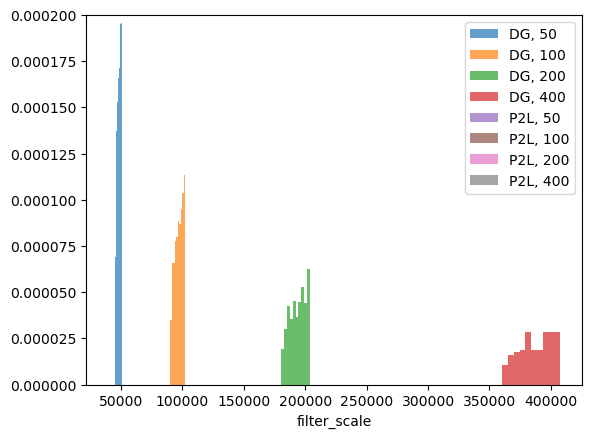

In [26]:
DT.simulation_data['DG']['50'].filter_scale.plot(density=True, alpha=0.7, label='DG, 50')
DT.simulation_data['DG']['100'].filter_scale.plot(density=True, alpha=0.7, label='DG, 100');
DT.simulation_data['DG']['200'].filter_scale.plot(density=True, alpha=0.7, label='DG, 200');
DT.simulation_data['DG']['400'].filter_scale.plot(density=True, alpha=0.7, label='DG, 400');


# The ones below are single values
#DT.simulation_data['P2L']['50'].filter_scale.plot(density=True, alpha=0.7, label='P2L, 50')
#DT.simulation_data['P2L']['100'].filter_scale.plot(density=True, alpha=0.7, label='P2L, 100');
#DT.simulation_data['P2L']['200'].filter_scale.plot(density=True, alpha=0.7, label='P2L, 200');
#DT.simulation_data['P2L']['400'].filter_scale.plot(density=True, alpha=0.7, label='P2L, 400');

plt.legend()

plt.ylim(0, 2e-4)